# PINN - SIRD

A SIR model is a model describing how the number of susceptible, infected, recovered and dead persons co-vary.

The equations determing the realtionsship between these number are:

$$
\frac{ds}{dt} = \frac{-\beta s(t) i(t)}{N}  \\
$$
$$
\frac{di}{dt} = \frac{\beta s(t)i(t)}{N} -(\gamma + \mu) i(t) \\
$$
$$
\frac{dr}{dt} = \gamma i(t)
$$

$$
\frac{dd}{dt} = \mu i(t)
$$

The different parameters describes:

\- $\boldsymbol{\beta}$: Governs how contagious the diseas, how many of the infected persons will infect susceptible persons.

\- $\boldsymbol{\gamma}$: Governs how many of the infected persons that will recover.

\- $\boldsymbol{\mu}$: Governs how many of the infected persons that will die.

In this notebook I will try to solve a SIRD disease model first using an ordinary differential equation solver, then using a PINN. After that we will try to do parameter estimation based on the ODE solution using a PINN.

First we set up the parameter values and initial conditions for the equation:


In [136]:
# Define time domain:
T = 1000 
num_samples = 2046
num_boundary = 8

# Defining parameters:
beta = 1/50
gamma = 1/150
mu = 1/600

# Set initial values:
N = 10  
i0 = 1
r0 = 0
d0 = 0
s0 = N - i0 - r0 - d0

## Solve using ODE solver:

In [137]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

In [138]:
# Defining the derivatives of the equation.
def derivatives(y, t, N, beta, gamma, mu):
    s, i, r, d = y

    # Equations:
    ds_dt = - beta * s * i / N
    di_dt = beta * s * i / N - (gamma + mu) * i
    dr_dt = gamma * i
    dd_dt = mu * i 
    
    return ds_dt, di_dt, dr_dt, dd_dt

In [139]:
# Create time vector: 
t = np.linspace(0, T, num_samples)

# Set initial values
y0 = s0, i0, r0, d0

In [140]:
# Solve equation:
sol = integrate.odeint(derivatives, y0, t, args= (N, beta, gamma, mu))

# Get the values from the solution:
s_true, i_true, r_true, d_true = sol.T
s_true = s_true.reshape(-1, 1)
i_true = i_true.reshape(-1, 1)
r_true = r_true.reshape(-1, 1)
d_true = d_true.reshape(-1, 1)

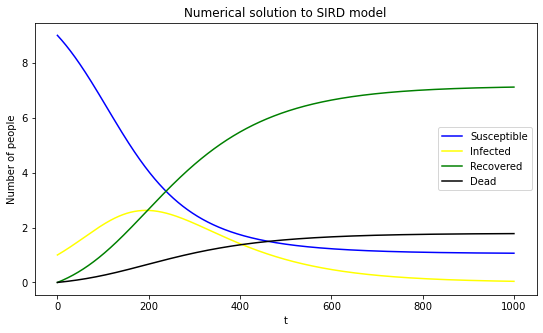

In [141]:
# Plot the solution:
plt.figure(figsize= (9, 5))
plt.plot(t, s_true, color="blue"), plt.plot(t, i_true, color="yellow"),
plt.plot(t, r_true, color="green"), plt.plot(t, d_true, color= "black")
plt.legend(["Susceptible", "Infected", "Recovered", "Dead"])
plt.title("Numerical solution to SIRD model")
plt.xlabel("t")
plt.ylabel("Number of people")

plt.savefig("figures/NumericalSIRD.png", dpi= 300)

## Solve using PINN:


In [142]:
import deepxde as dde

In [143]:
# Define the equations as a system of ODEs:
def ode_system(x, y):

    # Get output values from network:
    s = y[:, 0:1]
    i = y[:, 1:2]
    r = y[:, 2:3]
    d = y[:, 3:4]

    # Calculate gradients:
    ds_dt = dde.grad.jacobian(y, x, i= 0)
    di_dt = dde.grad.jacobian(y, x, i= 1)
    dr_dt = dde.grad.jacobian(y, x, i= 2)
    dd_dt = dde.grad.jacobian(y, x, i= 3)
    
    return [
    ds_dt + beta * s * i / N,
    di_dt - beta * s * i / N + gamma * i + mu * i,
    dr_dt - gamma * i,
    dd_dt - mu * i
    ]

In [144]:
# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0, T)

# Create the boundary function to determine if x is on the boundary or not:
def boundary(_, on_initial):
    return on_initial

# Specify the intial values:
ic_s = dde.IC(geom, lambda X: s0, boundary, component= 0)
ic_i = dde.IC(geom, lambda X: i0, boundary, component= 1)
ic_r = dde.IC(geom, lambda X: r0, boundary, component= 2)
ic_d = dde.IC(geom, lambda X: d0, boundary, component= 3)

In [145]:
# Create the equation:
data = dde.data.PDE(geom, ode_system, [ic_s, ic_i, ic_r, ic_d], num_samples, num_boundary, num_test=500)

In [146]:
# Define and create the neural network:
layer_size = [1] + [32] * 3 + [4]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

In [147]:
# Combine the data and network into a model:
model = dde.Model(data, net)

In [148]:
# Training:
model.compile("adam", lr=0.0001)
losshistory, train_state = model.train(epochs= 1000)

model.compile("adam", lr=0.00001)
losshistory, train_state = model.train(epochs= 150000, display_every= 10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.073264 s



/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-02 13:06:52.430987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-02 13:06:52.431059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 wit

'compile' took 0.620961 s

Initializing variables...


2021-12-02 13:06:53.258105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 13:06:53.444826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training model...

0         [4.28e-05, 9.23e-05, 1.53e-04, 5.78e-05, 8.10e+01, 1.00e+00, 0.00e+00, 0.00e+00]                                            [5.00e-06, 1.70e-05, 3.09e-05, 1.65e-05, 8.10e+01, 1.00e+00, 0.00e+00, 0.00e+00]                                            []  


2021-12-02 13:06:53.889642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000      [1.05e-04, 1.71e-05, 8.45e-06, 4.60e-06, 5.41e-02, 8.84e-06, 4.54e-09, 1.47e-13]                                            [7.04e-05, 1.66e-05, 5.21e-06, 4.27e-06, 5.41e-02, 8.84e-06, 4.54e-09, 1.47e-13]                                            []  

Best model at step 1000:
  train loss: 5.43e-02
  test loss: 5.42e-02
  test metric: []

'train' took 29.403879 s

Compiling model...
'compile' took 1.307000 s



2021-12-02 13:07:24.044579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 13:07:24.386048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 13:07:24.436282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
1000      [1.05e-04, 1.71e-05, 8.45e-06, 4.60e-06, 5.41e-02, 8.84e-06, 4.54e-09, 1.47e-13]    [7.04e-05, 1.66e-05, 5.21e-06, 4.27e-06, 5.41e-02, 8.84e-06, 4.54e-09, 1.47e-13]    []  


2021-12-02 13:07:24.781988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10000     [1.46e-05, 1.52e-05, 5.65e-07, 1.15e-06, 9.09e-13, 9.32e-11, 3.97e-11, 5.21e-12]    [4.58e-06, 1.53e-05, 5.52e-07, 1.14e-06, 9.09e-13, 9.32e-11, 3.97e-11, 5.21e-12]    []  
20000     [2.06e-06, 1.49e-05, 2.88e-07, 3.16e-08, 4.40e-10, 3.22e-10, 9.02e-13, 2.29e-10]    [3.83e-07, 1.49e-05, 2.87e-07, 3.19e-08, 4.40e-10, 3.22e-10, 9.02e-13, 2.29e-10]    []  
30000     [1.27e-06, 1.23e-05, 7.48e-07, 9.12e-08, 4.40e-10, 9.56e-11, 4.05e-14, 1.31e-13]    [7.89e-07, 1.23e-05, 7.48e-07, 9.15e-08, 4.40e-10, 9.56e-11, 4.05e-14, 1.31e-13]    []  
40000     [1.29e-06, 5.64e-06, 1.48e-06, 1.74e-07, 2.27e-11, 4.62e-11, 1.61e-10, 8.88e-11]    [1.19e-06, 5.65e-06, 1.48e-06, 1.72e-07, 2.27e-11, 4.62e-11, 1.61e-10, 8.88e-11]    []  
50000     [8.15e-07, 2.61e-06, 1.20e-06, 9.45e-08, 1.31e-09, 1.34e-10, 1.19e-10, 9.70e-12]    [7.94e-07, 2.62e-06, 1.19e-06, 9.28e-08, 1.31e-09, 1.34e-10, 1.19e-10, 9.70e-12]    []  
60000     [5.14e-07, 1.40e-06, 8.79e-07, 7.50e-08, 1.78e-10, 1.08e-10, 8.84e-11, 1.36

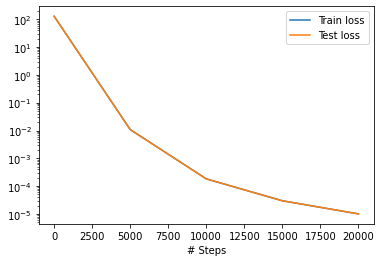

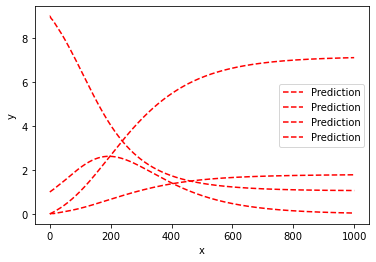

In [159]:
# Plot:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

2021-12-02 14:16:59.406610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


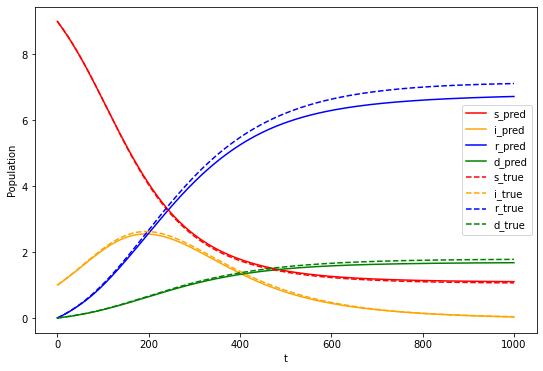

In [150]:
t = np.reshape(np.linspace(0, T, num_samples), (-1, 1))
sol_pred = model.predict(t)
s_pred = sol_pred[:, 0:1]
i_pred = sol_pred[:, 1:2]
r_pred =sol_pred[:, 2:3]
d_pred = sol_pred[:, 3:4]

plt.figure(figsize= (9, 6))
plt.xlabel("t")
plt.ylabel("Population")
plt.plot(t, s_pred, color="red", label="s_pred")
plt.plot(t, i_pred, color="orange", label="i_pred")
plt.plot(t, r_pred, color="blue", label="r_pred")
plt.plot(t, d_pred, color="green", label="d_pred")
plt.plot(t, s_true, color="red", label="s_true", linestyle="dashed")
plt.plot(t, i_true, color="orange", label="i_true", linestyle="dashed")
plt.plot(t, r_true, color="blue", label="r_true", linestyle="dashed")
plt.plot(t, d_true, color="green", label="d_true", linestyle="dashed")
plt.legend()
plt.show()

## Solve inverse problem using PINN:

In [151]:
# Get the solution from the ODE solver:
s_true, i_true, r_true, d_true = sol.T
y_true = np.concatenate([s_true.reshape(-1, 1),
                    i_true.reshape(-1, 1),
                    r_true.reshape(-1, 1),
                    d_true.reshape(-1, 1)], axis= 1)


In [152]:
# Defining the variables we want to estimate:
est_beta = dde.Variable(0.0)
est_gamma = dde.Variable(0.0)
est_mu = dde.Variable(0.0)

In [153]:
# Define the equations as a system of ODEs:
def ode_system(x, y):

    # Get output values from network:
    s = y[:, 0:1]
    i = y[:, 1:2]
    r = y[:, 2:3]
    d = y[:, 3:4]

    # Calculate gradients:
    ds_dt = dde.grad.jacobian(y, x, i= 0)
    di_dt = dde.grad.jacobian(y, x, i= 1)
    dr_dt = dde.grad.jacobian(y, x, i= 2)
    dd_dt = dde.grad.jacobian(y, x, i= 3)
    
    return [
    ds_dt + est_beta * s * i / N,
    di_dt - est_beta * s * i / N + est_gamma * i + mu * i,
    dr_dt - est_gamma * i,
    dd_dt - est_mu * i
    ]

In [154]:
# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0, T)

# Create the time vector for the known data:
t = np.reshape(np.linspace(0, T, num_samples), (num_samples, 1))

# Create the boundary function to determine if x is on the boundary or not:
def boundary(_, on_initial):
    return on_initial

# Specify the intial values:
ic_s = dde.IC(geom, lambda X: s0, boundary, component= 0)
ic_i = dde.IC(geom, lambda X: i0, boundary, component= 1)
ic_r = dde.IC(geom, lambda X: r0, boundary, component= 2)
ic_d = dde.IC(geom, lambda X: d0, boundary, component= 3)

# Define the boundary conditions from the solution of the ODE solver:
observe_s = dde.PointSetBC(t, y_true[:, 0:1], component= 0)
observe_i = dde.PointSetBC(t, y_true[:, 1:2], component= 1)
observe_r = dde.PointSetBC(t, y_true[:, 2:3], component= 2)
observe_d = dde.PointSetBC(t, y_true[:, 3:4], component= 3)

In [155]:
# Define the data class:
data = dde.data.PDE(
    geom,
    ode_system,
    [ic_s, ic_i, ic_r, ic_d, observe_s, observe_i, observe_r, observe_d],
    num_domain= num_samples,
    num_boundary= num_boundary,
    anchors= t)

In [156]:
# Define and create the neural network:
layer_size = [1] + [32] * 3 + [4]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

Compiling model...
Building feed-forward neural network...
'build' took 0.183126 s



/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-02 14:17:00.212707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-02 14:17:00.212771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 wit

'compile' took 1.851108 s

Initializing variables...


2021-12-02 14:17:02.463231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training model...



2021-12-02 14:17:02.709480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [6.76e-05, 2.12e-04, 5.55e-04, 1.70e-04, 8.10e+01, 1.00e+00, 0.00e+00, 0.00e+00, 1.10e+01, 3.81e+00, 3.01e+01, 3.20e+00]    [6.76e-05, 2.12e-04, 5.55e-04, 1.70e-04, 8.10e+01, 1.00e+00, 0.00e+00, 0.00e+00, 1.10e+01, 3.81e+00, 3.01e+01, 3.20e+00]    []  


2021-12-02 14:17:03.253996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 14:17:03.303587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5000      [2.45e-04, 1.49e-05, 1.38e-04, 1.19e-05, 1.68e-05, 7.31e-05, 9.99e-08, 1.73e-06, 4.54e-03, 3.99e-03, 1.15e-03, 6.49e-04]    [2.45e-04, 1.49e-05, 1.38e-04, 1.19e-05, 1.68e-05, 7.31e-05, 9.99e-08, 1.73e-06, 4.54e-03, 3.99e-03, 1.15e-03, 6.49e-04]    []  
10000     [2.32e-05, 9.43e-07, 7.83e-06, 3.37e-06, 1.31e-10, 1.08e-08, 2.40e-10, 8.96e-10, 3.33e-05, 4.72e-05, 3.44e-05, 3.17e-05]    [2.32e-05, 9.43e-07, 7.83e-06, 3.37e-06, 1.31e-10, 1.08e-08, 2.40e-10, 8.96e-10, 3.33e-05, 4.72e-05, 3.44e-05, 3.17e-05]    []  
15000     [5.75e-06, 2.35e-07, 2.85e-07, 9.01e-07, 6.63e-10, 1.98e-10, 2.94e-14, 2.19e-10, 3.67e-06, 4.51e-06, 7.07e-06, 7.20e-06]    [5.75e-06, 2.35e-07, 2.85e-07, 9.01e-07, 6.63e-10, 1.98e-10, 2.94e-14, 2.19e-10, 3.67e-06, 4.51e-06, 7.07e-06, 7.20e-06]    []  
20000     [2.37e-06, 2.07e-08, 4.49e-08, 1.52e-07, 5.82e-11, 1.42e-12, 3.83e-11, 6.97e-10, 1.74e-06, 1.03e-06, 1.72e-06, 2.89e-06]    [2.37e-06, 2.07e-08, 4.49e-08, 1.52e-07, 5.82e-11, 1.42e-12, 3.83e-11, 6.97e-

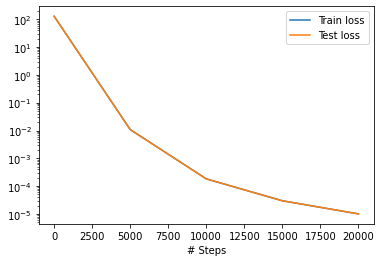

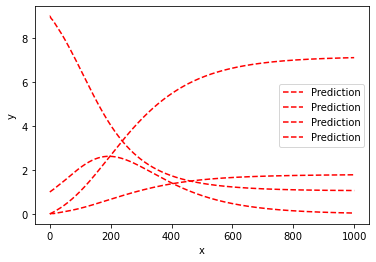

In [157]:
# Combine the data and network into a model:
est_model = dde.Model(data, net)
est_model.compile("adam", lr=0.0001, external_trainable_variables=[est_beta, est_gamma, est_mu])

# Define when to collect the updated values of the variables and save them to a file:
variable = dde.callbacks.VariableValue(
    [est_beta, est_gamma, est_mu], period=600, filename="variables.dat"
)

# Train the model:
losshistory, train_state = est_model.train(epochs=20000, callbacks=[variable], display_every= 5000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [158]:
print("The variables are estimated to be:")

for var in variable.get_value():
    print(round(var, 5))

print("While the true variables are:")
print(round(beta, 5)), print(round(gamma, 5)), print(round(mu, 5));

The variables are estimated to be:
0.01996
0.00667
0.00168
While the true variables are:
0.02
0.00667
0.00167
